# Energies for an asymmetric mixture (different sizes)

In this document we compare the excess energies calculated by our `Pairwise` implementation with the ones obtained from Monte Carlo simulations (MC) from [Wu et al. (1998)](https://doi.org/10.1021/ie950503r).

Since for the system investigated here the MC results are nearly very close to the AD model, this model is actually used in the comparisons.

We start by importing the necessary packages.

In [1]:
import math, os, sys
import matplotlib.pyplot as plt
import pandas as pd

parent_directory = os.path.dirname(os.path.abspath('.'))
sys.path.append(parent_directory)

from pysac import SAC, RGAS

### Compound definitions

For the symmetric case, we set both compounds as having an unitary area such that area fractions match molar fractions. Additionally, in order to compare the results with the cubic lattice system we need to set `Q_eff = 1/z`.


In [2]:
Q_1   = [1]
Q_2   = [10]

z = 6
Q_eff = 1/z

# The mixture area
Q = [Q_1, Q_2]

## Interaction energies

Here we study the case of a strongly non-ideal mixture, where the first compound (0-0) interaction is strongly attractive when compared to the others. We make the interaction energies temperature independent by evaluating them at a reference temperature `T0`.

In [3]:
T0 = 300

class MonomerStronglyNonIdeal(SAC):
    def __init__(self):
        super().__init__(Q_eff=Q_eff)

    def calc_u(self, T, i, j, m, n):
        if i == 0 and j == 0:
            return -0.65 * RGAS * T0
        if i == 1 and j == 1:
            return -0.1 * RGAS * T0
        
        return -0.2 * RGAS * T0

# Create an instance of our class
sac = MonomerStronglyNonIdeal()

# Set a temperature, we use the reference `T0` so we get the same
# results as in the original work.
T = T0
sac.set_compounds(Q)
sac.set_temperature(T)

### Excess properties

Here we calculate the excess Helmholtz and internal energy on multiple compositions. For the UNIQUAC model we use adjusted parameters so that the Helmholtz excess energy of both models match.

In the [ue_symmetric](./ue_symmetric.ipynb) notepad we assume the UNIQUAC interaction energies can be calculated directly from the pair contact energies as in [Wu et al. (1998)](https://doi.org/10.1021/ie950503r). In that case much worse UNIQUAC results are obtained.

[]

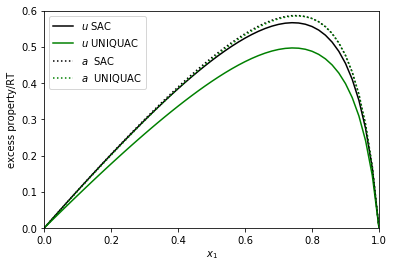

In [4]:
N = 51
ue_pw = []
ae_pw = []

ue_wil = []
ae_wil = []
x1 = []

# UNIQUAC parameters so that the Helmholtz of both models match
Lambda = [[1, 0.555], [0.555, 1]]

for l in range(N):
    x1_ = l/(N-1)
    x1.append(x1_)

    x = [x1_, 1-x1_]
    
    sac.set_composition(x)
    sac.calc_ln_gamma()

    ae_pw_ = sac.get_helmholtz()
    ue_pw_ = sac.get_energy()

    ue_wil_ = 0.0
    ae_wil_ = 0.0

    sum_ni_qi = 0.0
    for i in range(len(x)):
        sum_thetaj_Lambdaij = 0
        sum_thetaj_epsij_Lambdaij = 0
        sum_thetaj_Lambdaij = 0
        
        epsii = -math.log(sac.psi[i][i][0][0])

        for j in range(len(x)):
            Lambdaij = Lambda[i][j]
            epsij = -math.log(Lambdaij)

            sum_thetaj_Lambdaij += sac.theta[j][0] * Lambdaij
            
            sum_thetaj_epsij_Lambdaij += sac.theta[j][0] * epsij * Lambdaij
            
        ue_wil_ += Q[i][0]*x[i] * sum_thetaj_epsij_Lambdaij / sum_thetaj_Lambdaij
        ae_wil_ -= Q[i][0]*x[i] * math.log(sum_thetaj_Lambdaij)

    # subtract the pure compound energies
    for i in range(len(x)):
        ue_pw_ -= x[i]*sac.get_energy_pure(i)
        ae_pw_ -= x[i]*sac.get_helmholtz_pure(i)
    
    ae_pw.append(ae_pw_)
    ue_pw.append(ue_pw_)
    ue_wil.append(ue_wil_)
    ae_wil.append(ae_wil_)

plt.plot(x1, ue_pw, 'k-', label=r'$u$ SAC')
plt.plot(x1, ue_wil, 'g-', label=r'$u$ UNIQUAC')
plt.plot(x1, ae_pw, 'k:', label=r'$a$  SAC')
plt.plot(x1, ae_wil, 'g:', label=r'$a$  UNIQUAC')

plt.legend(loc='upper left')
plt.xlabel(r'$x_1$')
plt.ylabel(r'excess property/RT')
plt.xlim([0, 1])
plt.ylim([0, 0.6])


plt.rcParams.update({'font.size': 14})
plt.savefig('pdf/ue-excess-asymm.pdf')
plt.plot()